# Evaluating Models

## Imports

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import openpyxl

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

## Read in train dataset

In [2]:
# Load sample data from excel
api_df = pd.read_excel("../../data/processed/train_essentials.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.columns

Index(['is_pii', 'is_fii', 'NRI score', 'authentication_processed',
       'usage_base_processed', 'AI & Data Science', 'Business & Technology',
       'Environment & Weather', 'Finance & Banking',
       'GeoInformatics & Navigation', 'Government & Public Services',
       'Health Science & Medicine', 'Information & Science',
       'Justice & Public Safety', 'Logistics & Infrastructure',
       'Natural Resources & Energy', 'News & Media', 'None',
       'Religion & Spirituality', 'Research & Education', 'Sales & Marketing',
       'Security & Technology', 'Skills & Career Development',
       'Social Media & Technology', 'Software & Services',
       'Sports & Entertainment', 'Transportation & Automobile',
       'Work & Personal Life', 'eCommerce & Trade', 'Food, Health & Medicine',
       'server_name_processed', 'security_test_result_processed',
       'x0_Broken Authentication', 'x0_Cross-Site Scripting',
       'x0_Insecure Deserialization', 'x0_Missing', 'x0_SQL Injection',
  

In [4]:
# X, y split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
y_train.value_counts()

Medium    661
Low       651
High        4
Name: Risk_Label, dtype: int64

In [6]:
# Test data
test_df = pd.read_excel("../../data/processed/test_essentials.xlsx")
X_test, y_test = test_df.drop(columns=["Risk_Label"]), test_df["Risk_Label"]

## Confusion Matrix and Classification Report

In [7]:
pipe_lr_plot = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr_plot.fit(X_train, y_train)
y_pred = pipe_lr_plot.predict(X_train)

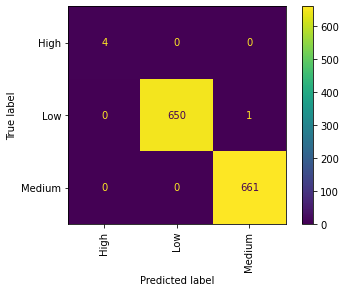

In [8]:
ConfusionMatrixDisplay.from_estimator(
    pipe_lr_plot, X_train, y_train, xticks_rotation="vertical"
);

In [9]:
print(
    classification_report(
        y_train, y_pred, target_names=["High", "Low", "Medium"]
    )
)

              precision    recall  f1-score   support

        High       1.00      1.00      1.00         4
         Low       1.00      1.00      1.00       651
      Medium       1.00      1.00      1.00       661

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316



# Helper Code

In [10]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [11]:
# Model evaluation set-up
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [12]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [13]:
# Balanced training data
X_train, y_train = create_smote(X_train, y_train, 2)

## Processed data + dummy model

In [14]:
X_processed = X_train[['authentication_processed','usage_base_processed', 
                 'AI & Data Science', 'Business & Technology',
       'Environment & Weather', 'Finance & Banking',
        'GeoInformatics & Navigation', 'Government & Public Services',
       'Health Science & Medicine', 'Information & Science',
       'Justice & Public Safety', 'Logistics & Infrastructure',
       'Natural Resources & Energy', 'News & Media', 'None',
       'Religion & Spirituality', 'Research & Education', 'Sales & Marketing',
       'Security & Technology', 'Skills & Career Development',
       'Social Media & Technology', 'Software & Services',
       'Sports & Entertainment', 'Transportation & Automobile',
       'Work & Personal Life', 'eCommerce & Trade', 'Food, Health & Medicine',
       'server_name_processed', 'security_test_result_processed']]

In [15]:
# Dummy Classifier Model
model_dummy = DummyClassifier(strategy="stratified", random_state=42)
results["Processed+Dummy"] = mean_std_cross_val_scores(
    model_dummy, X_processed, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Processed+Dummy
fit_time,0.001 (+/- 0.000)
score_time,0.006 (+/- 0.001)
test_accuracy,0.342 (+/- 0.019)
train_accuracy,0.331 (+/- 0.010)
test_f1_macro,0.342 (+/- 0.019)
train_f1_macro,0.331 (+/- 0.010)
test_recall_macro,0.342 (+/- 0.019)
train_recall_macro,0.331 (+/- 0.010)


## Processed data + tree model

In [16]:
# Logistic Regression Classifier Model
pipe_lr = make_pipeline(StandardScaler(), DecisionTreeClassifier())
results["Processed+DT"] = mean_std_cross_val_scores(
    pipe_lr, X_processed, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Processed+Dummy,Processed+DT
fit_time,0.001 (+/- 0.000),0.008 (+/- 0.004)
score_time,0.006 (+/- 0.001),0.007 (+/- 0.002)
test_accuracy,0.342 (+/- 0.019),0.743 (+/- 0.033)
train_accuracy,0.331 (+/- 0.010),0.771 (+/- 0.005)
test_f1_macro,0.342 (+/- 0.019),0.743 (+/- 0.033)
train_f1_macro,0.331 (+/- 0.010),0.771 (+/- 0.005)
test_recall_macro,0.342 (+/- 0.019),0.743 (+/- 0.033)
train_recall_macro,0.331 (+/- 0.010),0.771 (+/- 0.005)


## Processed data + logistic regression

In [17]:
# Logistic Regression Classifier Model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["Processed+LR"] = mean_std_cross_val_scores(
    pipe_lr, X_processed, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Processed+Dummy,Processed+DT,Processed+LR
fit_time,0.001 (+/- 0.000),0.008 (+/- 0.004),0.041 (+/- 0.005)
score_time,0.006 (+/- 0.001),0.007 (+/- 0.002),0.006 (+/- 0.001)
test_accuracy,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032)
train_accuracy,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007)
test_f1_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032)
train_f1_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007)
test_recall_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032)
train_recall_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007)


## Hyperparameter Optimization

In [18]:
param_grid = {"logisticregression__C": [100, 10, 1.0, 0.1, 0.01],                     # 10.0 ** np.arange(-3, 4),
             "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear']}

In [19]:
# Hyperparameter search
grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=20, n_jobs=-1, return_train_score=True
)

results_gs = grid_search.fit(X_processed, y_train)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [20]:
results_gridsearch = pd.DataFrame(results_gs.cv_results_)
#results_gridsearch.T

In [21]:
grid_search.best_params_

{'logisticregression__C': 1.0, 'logisticregression__solver': 'liblinear'}

In [22]:
# Logistic Regression Classifier Model
pipe_lr_tuned = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, solver='liblinear'))
results["Processed+LR_tuned"] = mean_std_cross_val_scores(
    pipe_lr_tuned, X_processed, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Processed+Dummy,Processed+DT,Processed+LR,Processed+LR_tuned
fit_time,0.001 (+/- 0.000),0.008 (+/- 0.004),0.041 (+/- 0.005),0.047 (+/- 0.046)
score_time,0.006 (+/- 0.001),0.007 (+/- 0.002),0.006 (+/- 0.001),0.008 (+/- 0.001)
test_accuracy,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032)
train_accuracy,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007)
test_f1_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032)
train_f1_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007)
test_recall_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032)
train_recall_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007)


## Feature Engineering

In [23]:
# Logistic Regression Classifier Model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["Engineered+LR"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Processed+Dummy,Processed+DT,Processed+LR,Processed+LR_tuned,Engineered+LR
fit_time,0.001 (+/- 0.000),0.008 (+/- 0.004),0.041 (+/- 0.005),0.047 (+/- 0.046),0.054 (+/- 0.040)
score_time,0.006 (+/- 0.001),0.007 (+/- 0.002),0.006 (+/- 0.001),0.008 (+/- 0.001),0.007 (+/- 0.000)
test_accuracy,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032),0.995 (+/- 0.003)
train_accuracy,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007),0.999 (+/- 0.000)
test_f1_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032),0.995 (+/- 0.003)
train_f1_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007),0.999 (+/- 0.000)
test_recall_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032),0.995 (+/- 0.003)
train_recall_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007),0.999 (+/- 0.000)


## Feature Selection

In [24]:
X_selected = X_train[['is_pii', 'is_fii', 'authentication_processed',
       'security_test_result_processed', 'x0_Broken Authentication',
       'x0_Missing', 'access-control-allow-origin', 'server']]

In [25]:
# Logistic Regression Classifier Model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["Selected+LR"] = mean_std_cross_val_scores(
    pipe_lr, X_selected, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Processed+Dummy,Processed+DT,Processed+LR,Processed+LR_tuned,Engineered+LR,Selected+LR
fit_time,0.001 (+/- 0.000),0.008 (+/- 0.004),0.041 (+/- 0.005),0.047 (+/- 0.046),0.054 (+/- 0.040),0.024 (+/- 0.009)
score_time,0.006 (+/- 0.001),0.007 (+/- 0.002),0.006 (+/- 0.001),0.008 (+/- 0.001),0.007 (+/- 0.000),0.008 (+/- 0.004)
test_accuracy,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032),0.995 (+/- 0.003),0.998 (+/- 0.001)
train_accuracy,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007),0.999 (+/- 0.000),0.998 (+/- 0.000)
test_f1_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032),0.995 (+/- 0.003),0.998 (+/- 0.001)
train_f1_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007),0.999 (+/- 0.000),0.998 (+/- 0.000)
test_recall_macro,0.342 (+/- 0.019),0.743 (+/- 0.033),0.748 (+/- 0.032),0.748 (+/- 0.032),0.995 (+/- 0.003),0.998 (+/- 0.001)
train_recall_macro,0.331 (+/- 0.010),0.771 (+/- 0.005),0.766 (+/- 0.007),0.765 (+/- 0.007),0.999 (+/- 0.000),0.998 (+/- 0.000)


## Confusion Matrix

In [26]:
pipe_lr_plot = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr_plot.fit(X_processed, y_train)
y_pred = pipe_lr_plot.predict(X_processed)

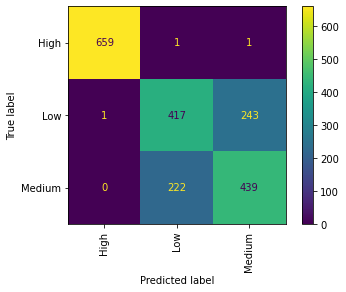

In [27]:
ConfusionMatrixDisplay.from_estimator(
    pipe_lr_plot, X_processed, y_train, xticks_rotation="vertical"
);

In [28]:
print(
    classification_report(
        y_train, y_pred, target_names=["High", "Low", "Medium"]
    )
)

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       661
         Low       0.65      0.63      0.64       661
      Medium       0.64      0.66      0.65       661

    accuracy                           0.76      1983
   macro avg       0.76      0.76      0.76      1983
weighted avg       0.76      0.76      0.76      1983

